In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import ResNet50V2

In [3]:
train_dir = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\train\\'
test_dir = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\test\\'

def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

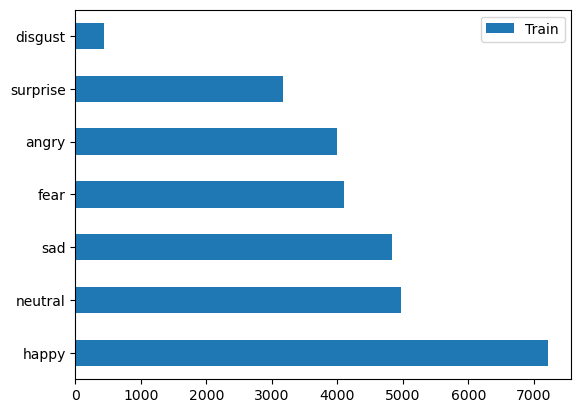

In [5]:
Train_Count.plot(kind='barh')

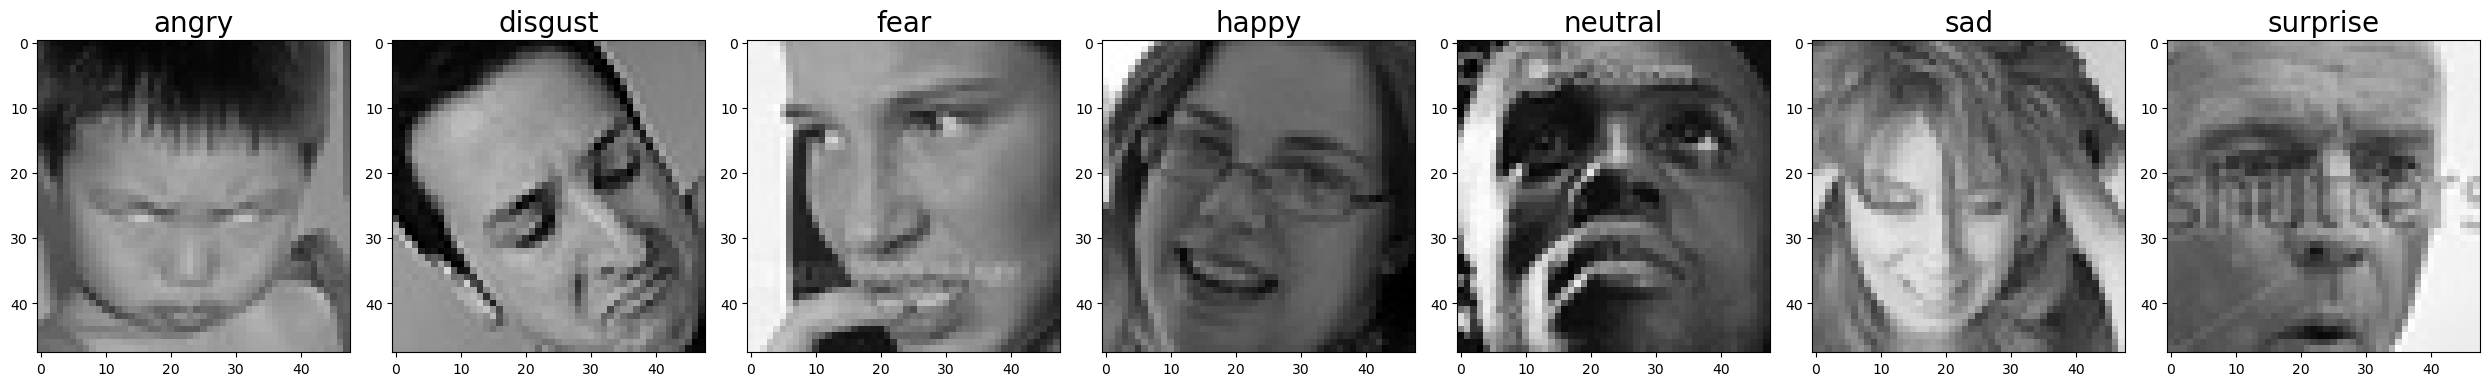

In [6]:
plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1
BASE_URL = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\train\\'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        dir_path = os.path.join(BASE_URL, directory)
        for i, file in enumerate(os.listdir(dir_path)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                file_path = os.path.join(dir_path, file)
                
                image = cv2.imread(file_path)
                if image is not None:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    plt.imshow(image_rgb)
                    plt.title(directory, fontsize=20)
                else:
                    print(f"Failed to load image: {file_path}")

plt.tight_layout()
plt.show()

In [7]:
img_shape = 48
batch_size = 64
train_data_path = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\train\\'
test_data_path = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\test\\'

In [8]:
# Set up data preprocessing
train_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

# Create data generators
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
def Create_CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape,img_shape,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #Output

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))

    return model


In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\dsilv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,837,895 (29.90 MB)

 Trainable params: 7,832,519 (29.88 MB)

 Non-trainable params: 5,376 (21.00 KB)

Callbacks

In [11]:
checkpoint_path = "CNN_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)

Early_Stopping = EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)

callbacks = [Checkpoint, Early_Stopping, Reducing_LR]

# Calculate steps per epoch
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size -10

In [ ]:
CNN_history = CNN_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

C:\Users\dsilv\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1833 - loss: 2.2186
Epoch 1: val_accuracy improved from -inf to 0.27359, saving model to CNN_Model_Checkpoint.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 128s 274ms/step - accuracy: 0.1834 - loss: 2.2182 - val_accuracy: 0.2736 - val_loss: 1.7670 - learning_rate: 0.0010
Epoch 2/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:52 251ms/step - accuracy: 0.2188 - loss: 1.8660

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.27359
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2188 - loss: 1.8660 - val_accuracy: 0.1169 - val_loss: 2.4249 - learning_rate: 0.0010
Epoch 3/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2678 - loss: 1.8022
Epoch 3: val_accuracy improved from 0.27359 to 0.29733, saving model to CNN_Model_Checkpoint.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.2679 - loss: 1.8022 - val_accuracy: 0.2973 - val_loss: 1.6754 - learning_rate: 0.0010
Epoch 4/25
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:50 246ms/step - accuracy: 0.3750 - loss: 1.6446
Epoch 4: val_accuracy improved from 0.29733 to 0.52615, saving model to CNN_Model_Checkpoint.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 1.6446 - val_accuracy: 0.5262 - val_loss: 1.6155 - learning_rate: 0.0010
Epoch 5/25
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.3202 - loss: 1.6913
Epoch 5: val_accuracy did not improve from 0.52615
448/44

In [12]:
print("Total training samples:", train_data.n)
print("Total validation samples:", test_data.n)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Total training samples: 28709
Total validation samples: 7178
Steps per epoch: 448
Validation steps: 102


In [13]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}".format(CNN_Score[1] * 100))

 26/113 ━━━━━━━━━━━━━━━━━━━━ 31s 363ms/step - accuracy: 0.0000e+00 - loss: 3.1365

KeyboardInterrupt: 

In [ ]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = "training_loss")
    plt.plot(epochs,val_loss,label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(epochs,loss,label = "training_accuracy")
    plt.plot(epochs,val_loss,label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [ ]:
plot_curves(CNN_history)

In [14]:
CNN_Predictions = CNN_Model.predict(test_data)
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

 54/113 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step

KeyboardInterrupt: 

In [ ]:
test_data.class_indices

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [20]:
img_shape = 224
batch_size = 64
train_data_path = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\train\\'
test_data_path = 'C:\\Users\\dsilv\\development\\Emotion Detection\\data\\test\\'

In [21]:
# Set up data preprocessing
train_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

# Create data generators
train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [22]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224,224,3), include_top = False, weights = 'imagenet')

In [23]:
ResNet50V2.trainable = True

for layers in ResNet50V2.layers[:-50]:
    layers.trainable = False

In [24]:
def Create_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2,
        Dropout(.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(7, activation='softmax')
    ])
    return model

In [25]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [26]:
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

# Calculate steps per epoch
steps_per_epoch = 28709 // batch_size  # Correctly covers all training samples
validation_steps = 7178 // batch_size  # Correctly covers all validation samples

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/25
 18/448 ━━━━━━━━━━━━━━━━━━━━ 16:51 2s/step - accuracy: 0.6150 - loss: 1.0668

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}".format(ResNet50V2_Score[1] * 100))

In [ ]:
plot_curves(ResNet50V2_history)

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
Emotion_Classes = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Neutral',
    'Sad',
    'Surprise'
]

In [16]:
test_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 7178 images belonging to 7 classes.


NameError: name 'ResNet50V2_Model' is not defined

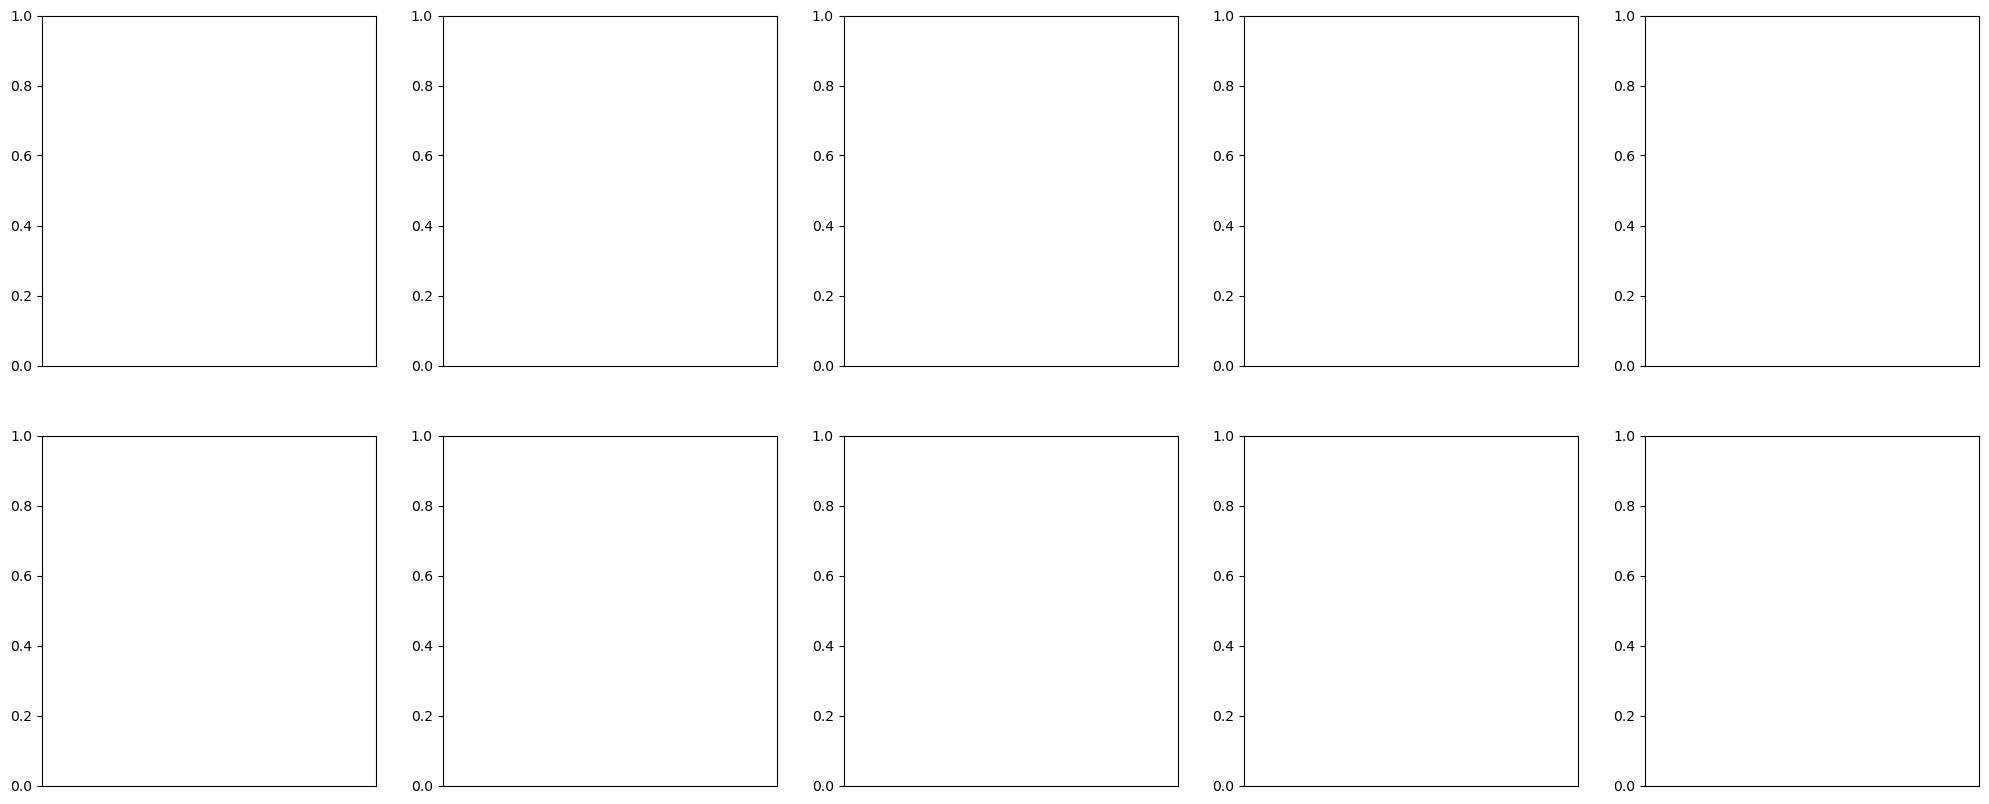

In [19]:
Random_Batch = np.random.randint(0, len(test_generator)- 1) 
Random_Img_Index = np.random.randint(0,batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,10), subplot_kw={'xticks':[], 'xticks':[]})

for i,ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_Batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_Batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(ResNet50V2_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted : {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [1]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

'wget' is not recognized as an internal or external command,
operable program or batch file.


NameError: name 'cv2' is not defined